# Data Exploration Project

## Ziel des Projektes und Auswahl des Datensatzes

Das Ziel des Projektes ist es ein ML-Model zu entwickeln welches auf der Basis von frei verfügbaren Online-Schach-Daten der Platform Lichess das Ergebnis eines Spieles voraussagen kann.

Der Datensatz stammt wie bereits eingangs erwähnt stammt von der Online-Schach Plattform Lichess.org.

Die Daten die hier verwendet werden sind durch die Lichess API: https://github.com/lichess-org/lila  gesammelt worden. 

Außerdem wurden sie auf Kaggle veröffentlicht: https://www.kaggle.com/datasets/datasnaek/chess/data

Lichess stellt weitere Daten unter folgendem Link zur verfügung: https://database.lichess.org/

In der Datenbank sind hunderte Gigabyte dieser Daten verfügbar, somit können auch noch deutlich komplexere Modelle trainiert werden. Für die Zwecke dieses Projektes sind die Daten von Kaggle jedoch zuerst ausreichend.

Die Auswahl dieses Datensatzes wurde vorallem deswegen getätigt da die qualität der Daten gut ist und viele relevante Metadaten verfügbar sind.

Für unser Modell gibt es 3 Mögliche Ergebnisse die vorheresagt werden können:
-  Schwarz gewinnt
-  Weiß gewinnt 
-  Remis

Hierbei handelt es sich somit um eine Klassifikationsaufgabe.

Das Repository ist unter folgendem Link zu finden: https://github.com/J0hnEbert/DEP

## Data Exploration

Zuerst werden die benötigten Bibliotheken importiert und die Daten geladen.

In [16]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier


# load the data
df = pd.read_csv('data/games.csv', ) 

Anschließend werfen wir einen ersten Blick auf die Daten um die Struktur und beschaffenheit nachvollziehen zu können.

In [17]:
print(df.head())
print(df.shape)
print(df.info())
print(df.describe())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

Nun haben wir einen ersten Überblick über die Daten und können festellen das es insgesammt 16 features gibt.

Es ist zu erkennen das es einige features gibt welche nicht numerisch sind, diese müssen umgewandelt werden, so zum Beispiel das Feature 'winner' welches das resultat der Partie wiedergibt. 

Außerdem ist zu erkennen das es keine fehlenden Werte gibt da die Anzahl der non-null werte mit der Anzahl an Zeilen übereinstimmt.

Auch bei der  Zeitangabe wird ein untypisches Format benutzt welches wir zunächst umwandeln müssen um es zu verwenden.

Andere Features wie beispielsweise die exakte Abfolge von zügen müssen entfernt werden da sie die Vorhersage irrelevant machen würden da sich so das Ergebnis einfach berechnen lassen würde.

Folgende Variablen werden aus dem Model ausgeschlossen da sie entweder mit hoher Wahrscheinlichkeit keinen Einfluss haben oder zu verfälschten Ergebnissen führen würden:
- white_id
- moves
- black_id
- opening_name
- id
- victory_status 
- opening_eco
- opening_ply

In [18]:
# List of features to be removed
columns_to_drop = ["moves", "black_id", "white_id","opening_name","id", "victory_status", "opening_ply", "opening_eco"]

# Dropping features
df.drop(columns=columns_to_drop, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rated           20058 non-null  bool   
 1   created_at      20058 non-null  float64
 2   last_move_at    20058 non-null  float64
 3   turns           20058 non-null  int64  
 4   winner          20058 non-null  object 
 5   increment_code  20058 non-null  object 
 6   white_rating    20058 non-null  int64  
 7   black_rating    20058 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 1.1+ MB
None


Nachdem die erwähnten Features entfernt wurden bleiben folgende Features:
- rated
- created_at
- last_move_at
- turns
- winner
- increment_code
- white_rating
- black_rating

Diese Feature werden verwendet um das model zu trainieren, zuerst müssen sie jedoch in das richtige format gebracht werden.


In [19]:
# Convert timestamps
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')

# Extract date and time components
df['hour_of_day'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df['day_of_month'] = df['created_at'].dt.day
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year

# Calculate game duration in minutes
df['game_duration'] = (df['last_move_at'] - df['created_at']).dt.total_seconds() / 60

# Drop the original 'created_at' column 
df.drop(columns=['created_at'], inplace=True)

# Drop the 'last_move_at' column
df.drop('last_move_at', axis=1, inplace=True)


Anstatt der Startzeit und der Zeit des letzten Zuges wird nun die Dauer des Spiels verwendet, außerdem werden alle Datumskomponenten extreahiert und als seperates Feature gespeichert.

Anschließend werden nun folgende variablen transformiert:
- "increment_code", also die Zeit die jeder Spieler hat und das Inkrement nach jedem Zug werden geteilt gespeichert
- "rated" wird durch One-Hot Encoding in eigene Features aufgeteilt
- "winner" wird numerisch umgewandelt in: 1=weiß, 0=draw und -1=black
- Aus der Bewertung von Schwarz und Weiß (white_rating, black_rating) wird die differenz als neues feature gebildet und die Summe als Gesammtbewertung (total_elo) der Partie

In [20]:
# splitting the increment code into time control and increment
df[['time_control', 'increment']] = df['increment_code'].str.split('+', expand=True)
df.drop(columns=['increment_code'], inplace=True)

# One-Hot Encoding for the feature rated
df = pd.get_dummies(df, columns=['rated'])

# mapping the numerical values for the games outcome
outcome_mapping = {'white': 1, 'draw': 0, 'black': -1}
df['winner'] = df['winner'].map(outcome_mapping)

# calculating the total elo and elo difference
df['total_elo'] = df['white_rating'] + df['black_rating']
df['elo_difference'] = df['white_rating'] - df['black_rating']

# dropping all features that are no longer needed
df.drop(columns=['rated_True', 'rated_False', 'time_control', 'increment'], inplace=True)

# Change of Feature order for correlation matrix
current_columns = df.columns.tolist()
index_column1 = current_columns.index('winner')
index_column2 = current_columns.index('turns')
current_columns[index_column1], current_columns[index_column2] = current_columns[index_column2], current_columns[index_column1]
df = df[current_columns]

# visualizing the change in features
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   winner          20058 non-null  int64  
 1   turns           20058 non-null  int64  
 2   white_rating    20058 non-null  int64  
 3   black_rating    20058 non-null  int64  
 4   hour_of_day     20058 non-null  int32  
 5   day_of_week     20058 non-null  int32  
 6   day_of_month    20058 non-null  int32  
 7   month           20058 non-null  int32  
 8   year            20058 non-null  int32  
 9   game_duration   20058 non-null  float64
 10  total_elo       20058 non-null  int64  
 11  elo_difference  20058 non-null  int64  
dtypes: float64(1), int32(5), int64(6)
memory usage: 1.5 MB
None


Nun sind alle Daten soweit transformiert das sie zum trainieren des Models verwendet werden können, jetzt müssen sie zuerst betrachtet werden um mögliche Ausreißer oder magelnde Balanciertheit zu bearbeiten.

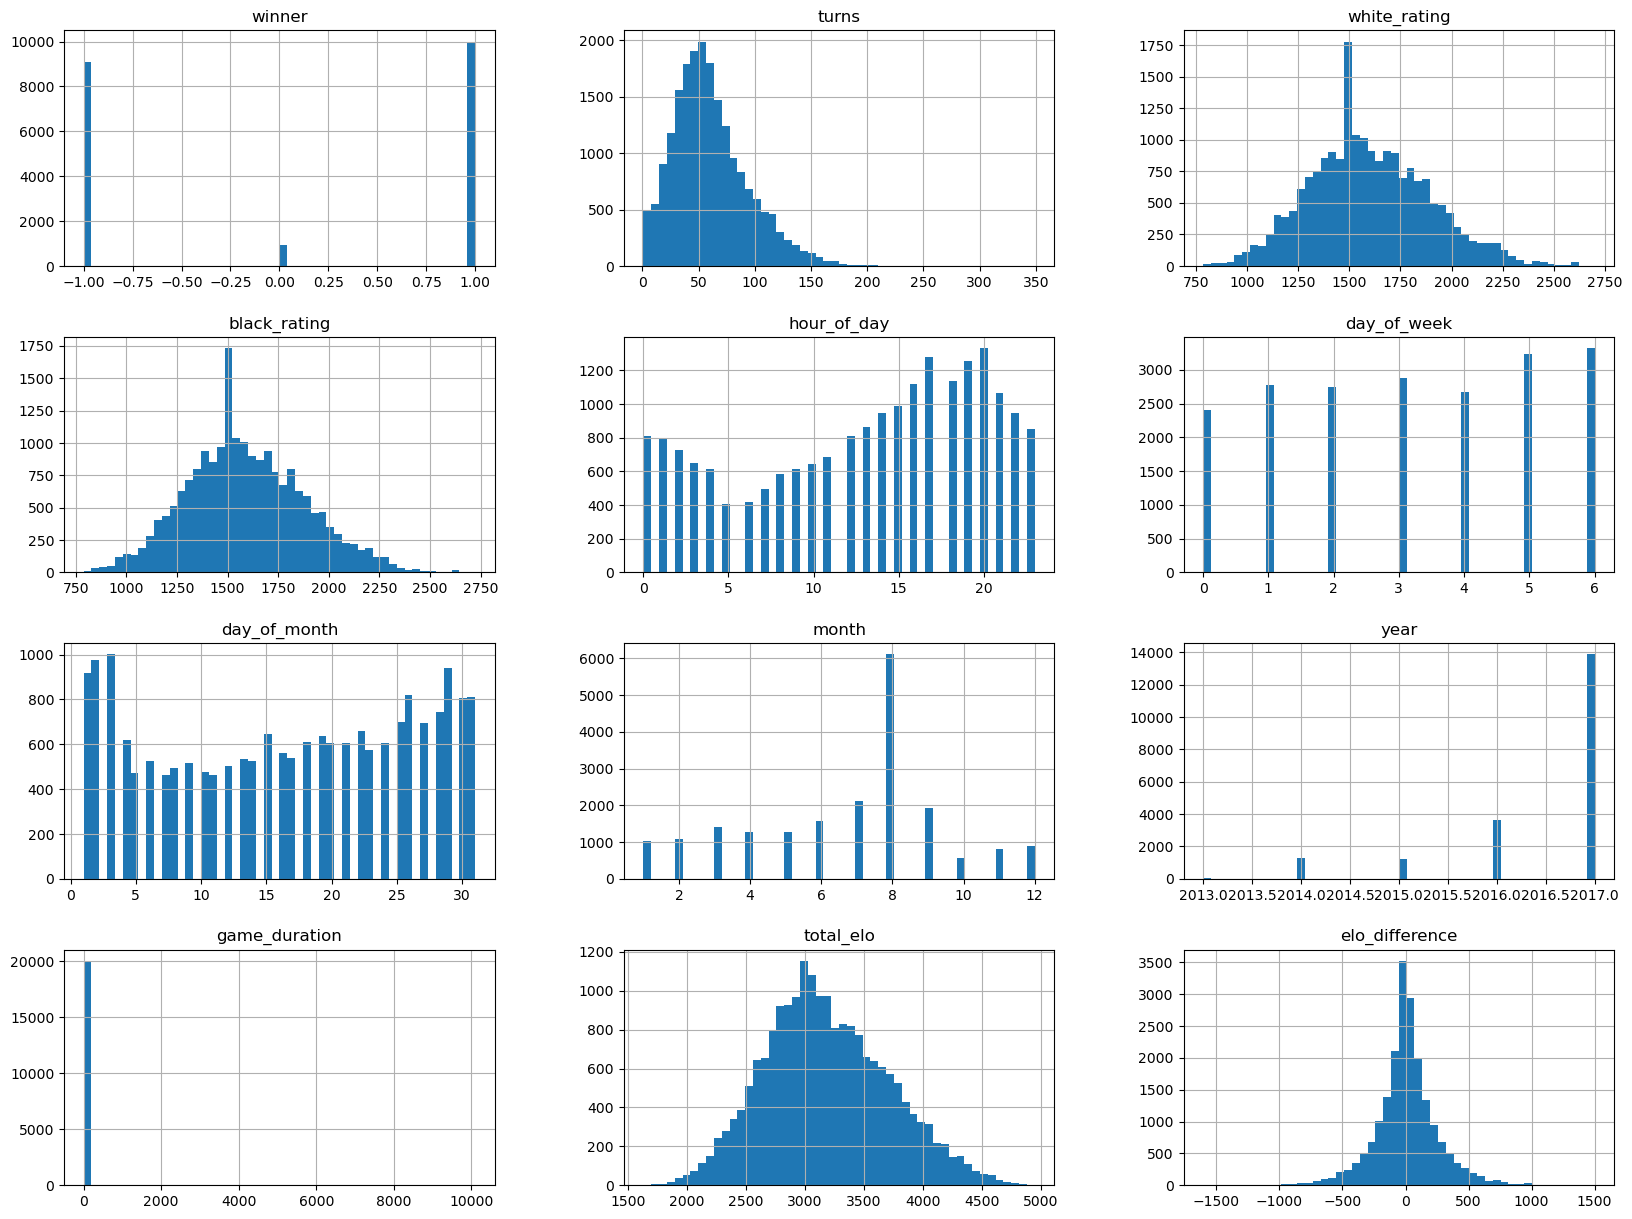

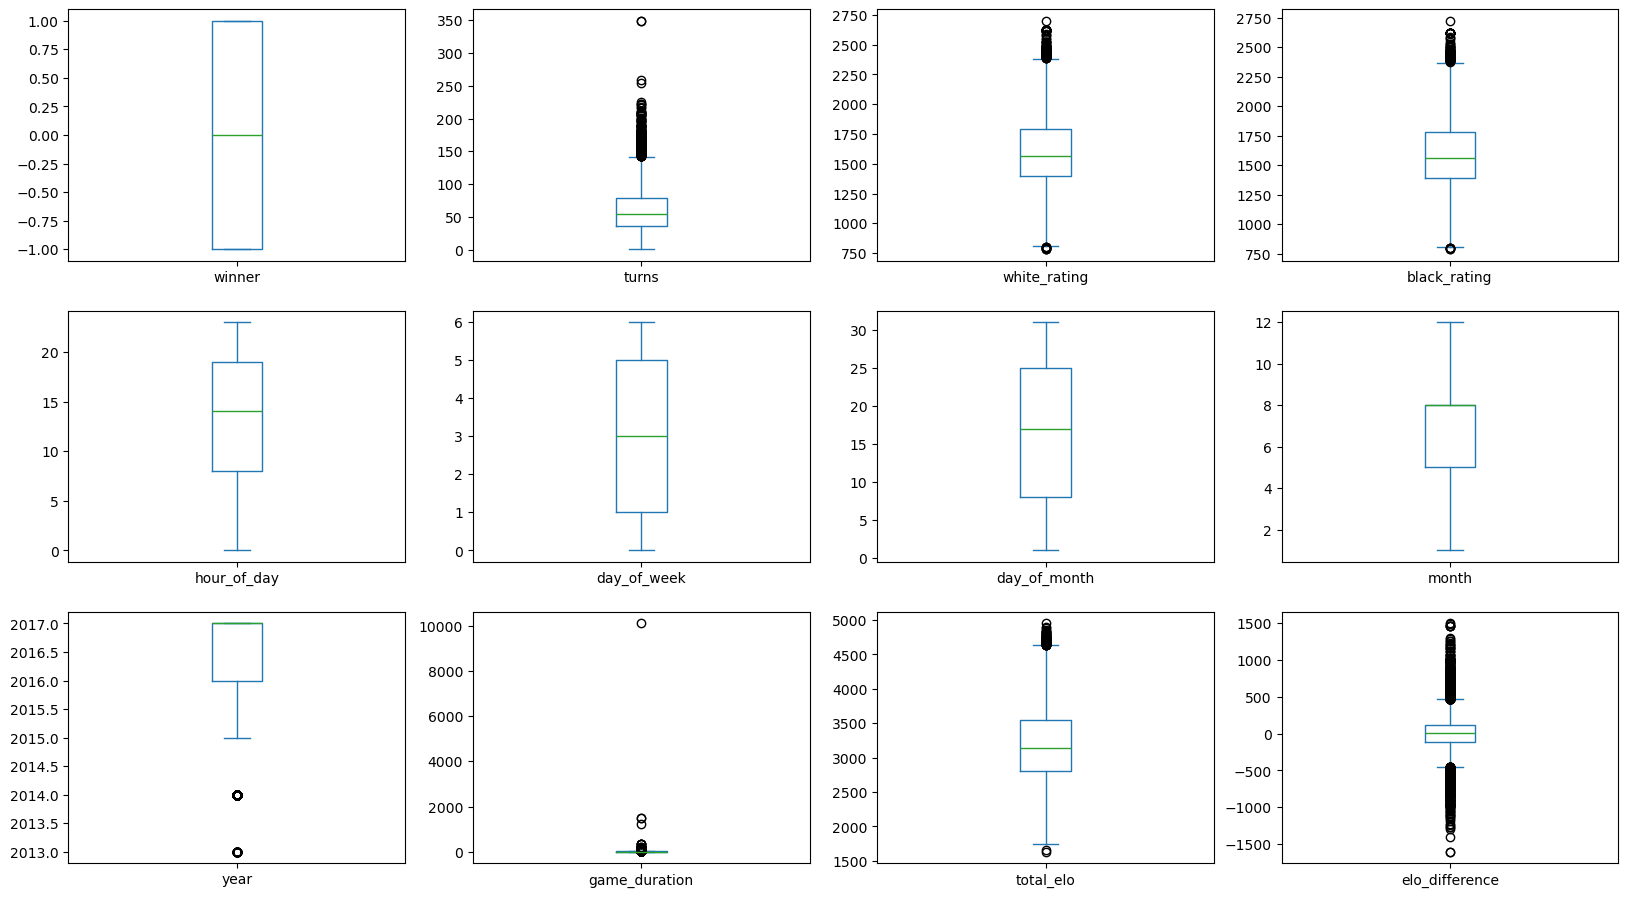

In [21]:
# Histogram of numerical data
df.hist(bins=50, figsize=(20,15))
plt.show()

# Boxplot of numerical data
df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 15))
plt.show()

Diese simple Visualiesierung verrät uns viel über die zu verwendenden Daten.

Nun muss abgewogen werden in welchen fällen es sich um sinnvolle ausreißer handelt und wo sie korregiert werden müssen da sie höchst wahrscheinlich fehler Darstellen:
- im Feature turns gibt es sehr viele Ausreißer im oberen quartil, diese müssen bereinigt werden da nach den offiziellen Regeln des Proffesionellen Schachs alles über 50 Züge automatisch ein unendschieden sein müsste
- Auch in der Spielzeit sehen wir eine große inkonsistenz hierbei handelt es sich bei den ausreißern höchstwahrscheinlich um fehler beim sammeln der Daten
- Ausreißer des features elo_difference müssen auch betrachtet werden da extreme unterschiede hier auf sehr eindeutige Partien hindeuten wo ein spieler deutlich höher bewertet ist als der andere
- Es gibt eine verhältnismäßig geringe Anzahl an Partien mit dem Ergebnis Unentschieden, dies muss korregiert werden um eine solide Datengrundlage für das Model zu garantieren

Alle anderen Ausreißer lassen sich durch Domänenwissen erklären und geben keinen anlass zur Sorge.

In [22]:
# Filter out the outliers of the feature 'turns'
Q1 = df['turns'].quantile(0.25)
Q3 = df['turns'].quantile(0.75)
IQR = Q3 - Q1
df = df.query('(@Q1 - 1.5 * @IQR) <= turns <= (@Q3 + 1.5 * @IQR)')

# Capping max playtime at 360 minutes
df = df[df['game_duration'] <= 360]

# Calculate the median of non-zero game durations
median_game_duration = df[df['game_duration'] > 0]['game_duration'].median()

# Replace all zero values in 'game_duration' with the calculated median
df['game_duration'] = df['game_duration'].replace(0, median_game_duration)

# Filter the DataFrame to remove entries where the Elo difference is over 500
df = df[df['elo_difference'].abs() <= 500]


Anschließend werden nun synthetische Daten durch lineare Interpolation erzeug und dem Dataframe hinzugefügt um mehr spiele mit dem Ergebniss "draw" zu haben und somit das Model besser trainieren zu können.

In [23]:
# Filter the dataframe 'df' to include only rows where the 'winner' column has the value 0 --> draw
draw_data = df[df['winner'] == 0]

def interpolate_features(data, target_samples):    
    # Initialize an empty list to store synthetic sample data
    synthetic_samples = []
    # Calculate the number of synthetic samples to generate per existing data point
    num_samples_per_instance = int(np.ceil(target_samples / len(data)))
    
    # Shift data by one row, fill the last row with the last non-NA value found before it
    shifted_data = data.shift(-1).ffill()  
    
    # Store the index of the last row
    max_index = len(data) - 1
    
    # Iterate through each row in the data frame
    for index, row in data.iterrows():
        # For the last row, wrap around to the first row for the 'next_row'
        if index < max_index:
            next_row = shifted_data.iloc[index]
        else:
            next_row = data.iloc[0]  
        
        # Generate synthetic samples between the current row and the next_row
        for i in range(num_samples_per_instance):
            # Compute the weight for interpolation
            alpha = (i + 1) / (num_samples_per_instance + 1)
            # Calculate interpolated features
            interpolated_features = row + (next_row - row) * alpha
            # Append the interpolated features to the synthetic_samples list
            synthetic_samples.append(interpolated_features)
            
    # Return the synthetic samples as a new DataFrame with the same columns as the input data
    return pd.DataFrame(synthetic_samples, columns=data.columns)


# Generate synthetic samples
synthetic_draw_data = interpolate_features(draw_data, target_samples=4000)
print("Synthetic samples shape:", synthetic_draw_data.shape)

# Add synthetic samples to the original dataset
df = pd.concat([df, synthetic_draw_data], ignore_index=True)

# Shuffle the dataset
df = shuffle(df)

Synthetic samples shape: (4105, 12)


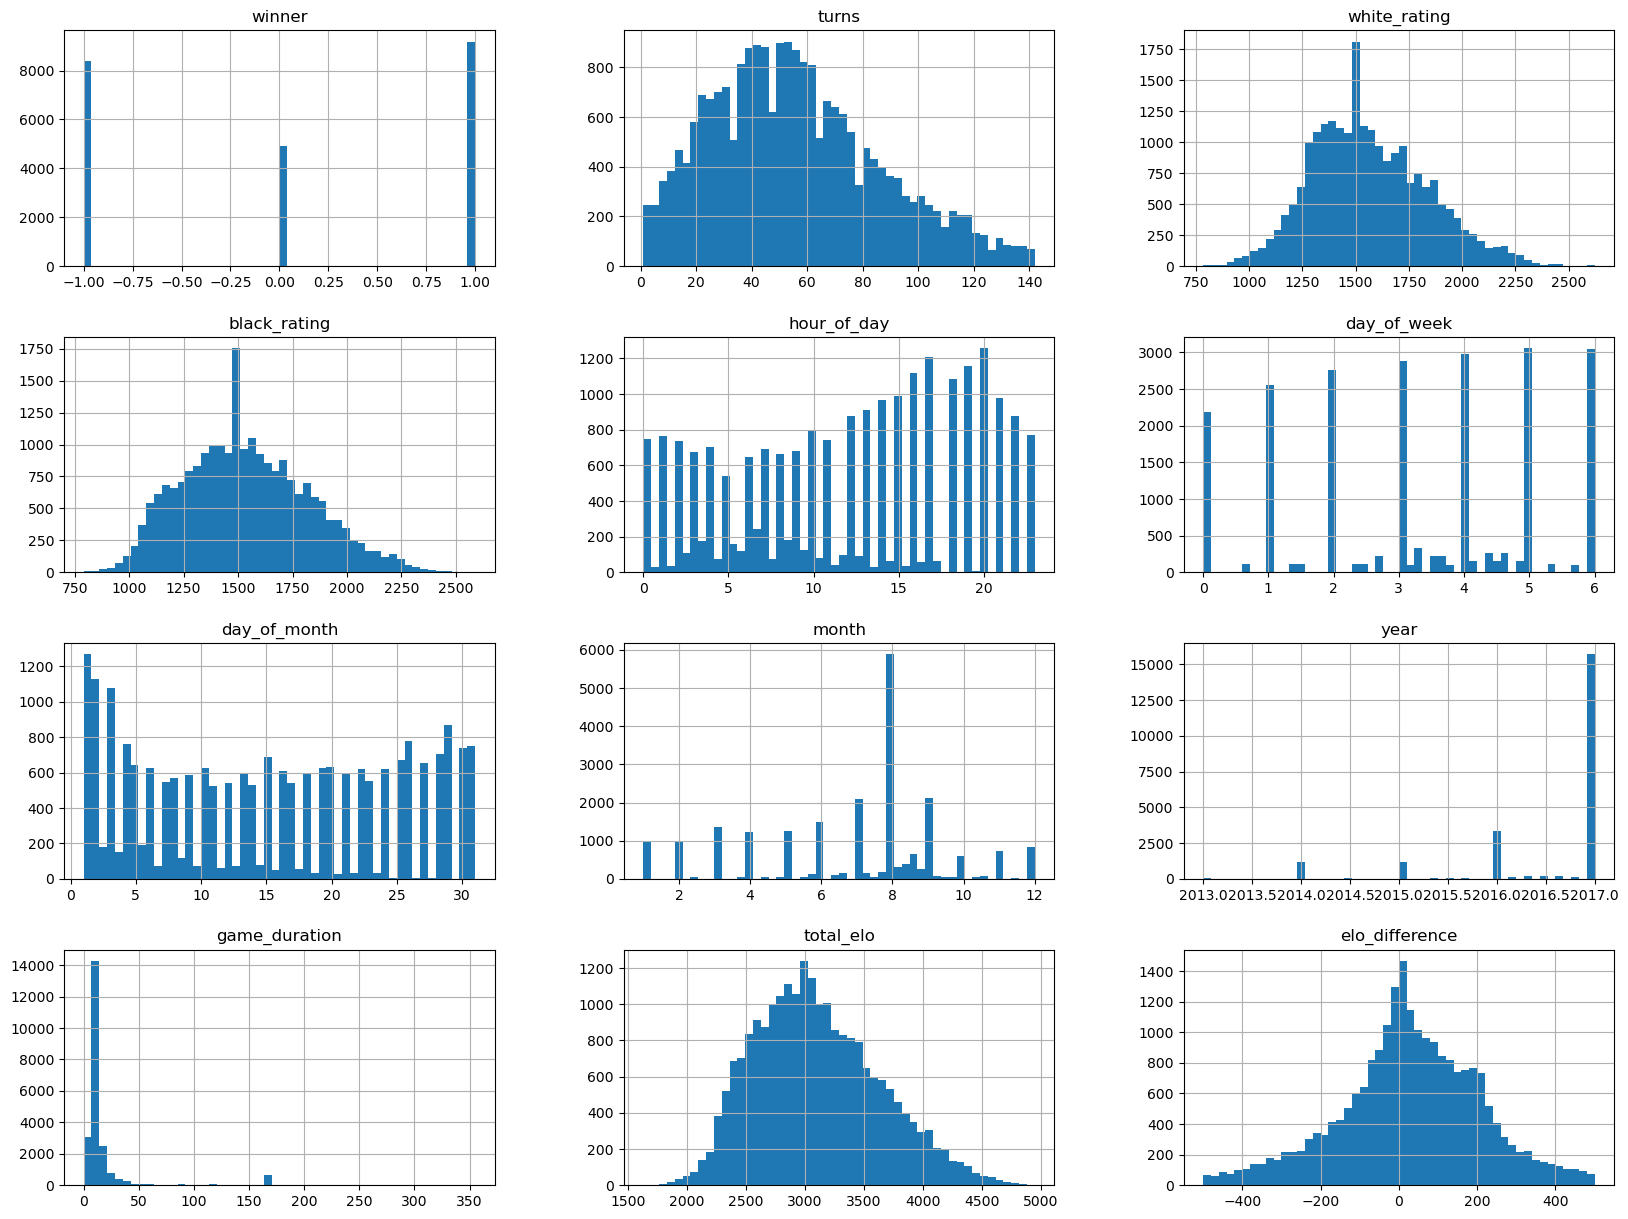

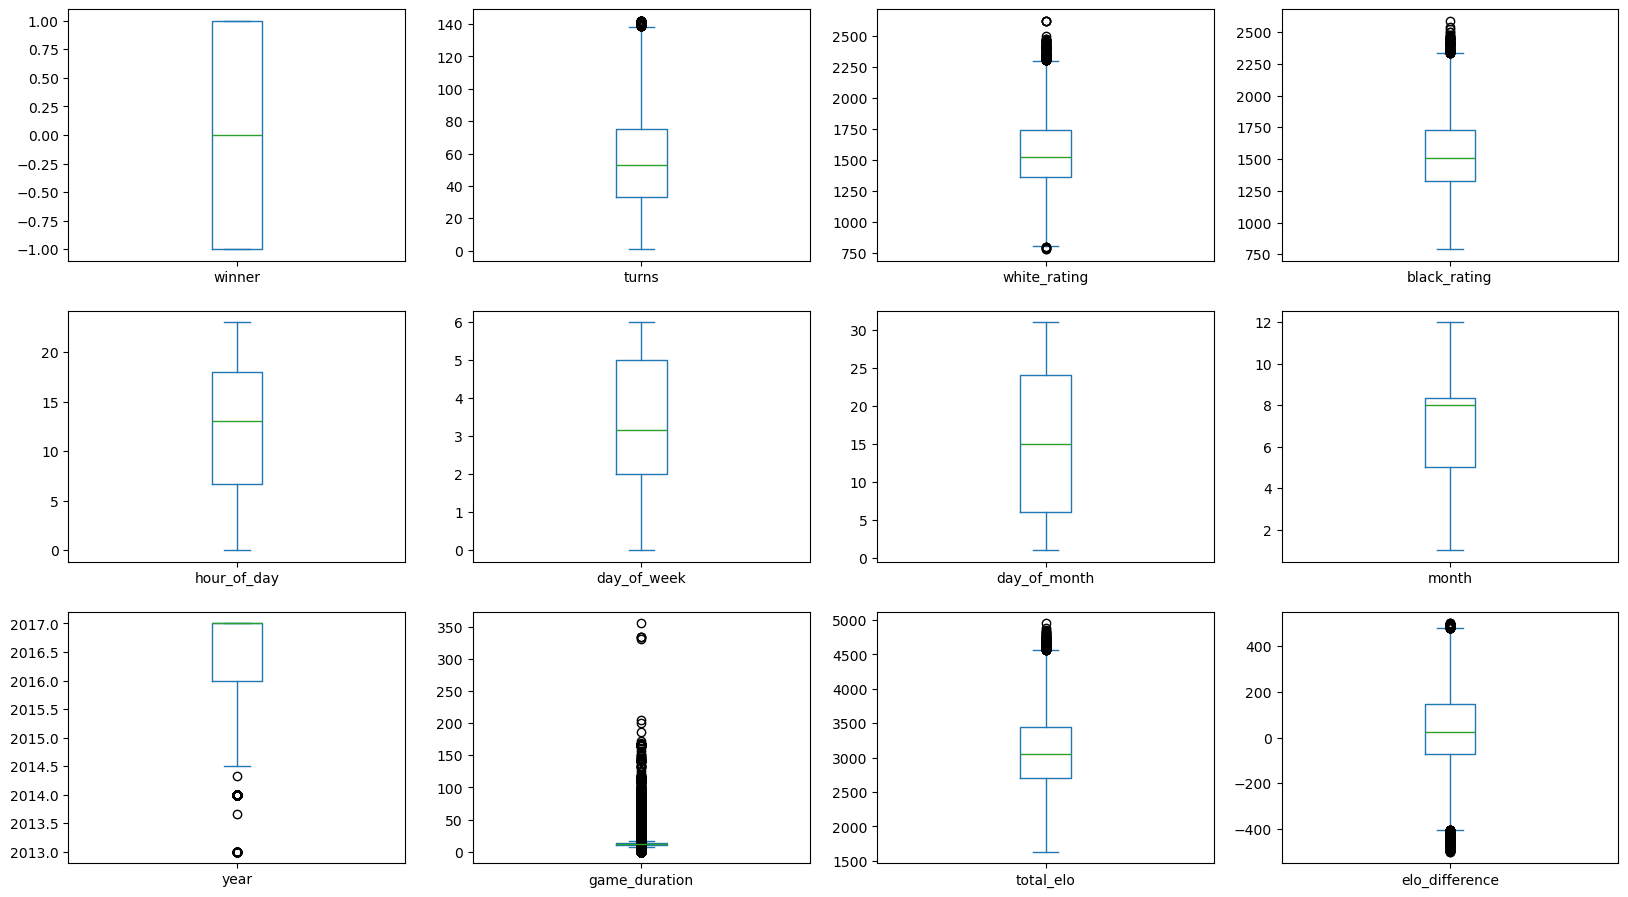

In [24]:
# Histogram of numerical data
df.hist(bins=50, figsize=(20,15))
plt.show()

# Boxplot of numerical data
df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 15))
plt.show()

Nun sind die Aureißer in ausreichendem Maße bereinigt, jetzt kann ein erster Blick auf die Feature-importance geworfen werden. 

Hierfür verwenden wir eine Korrealtionsmatrix, dargestellt als Heatmap.

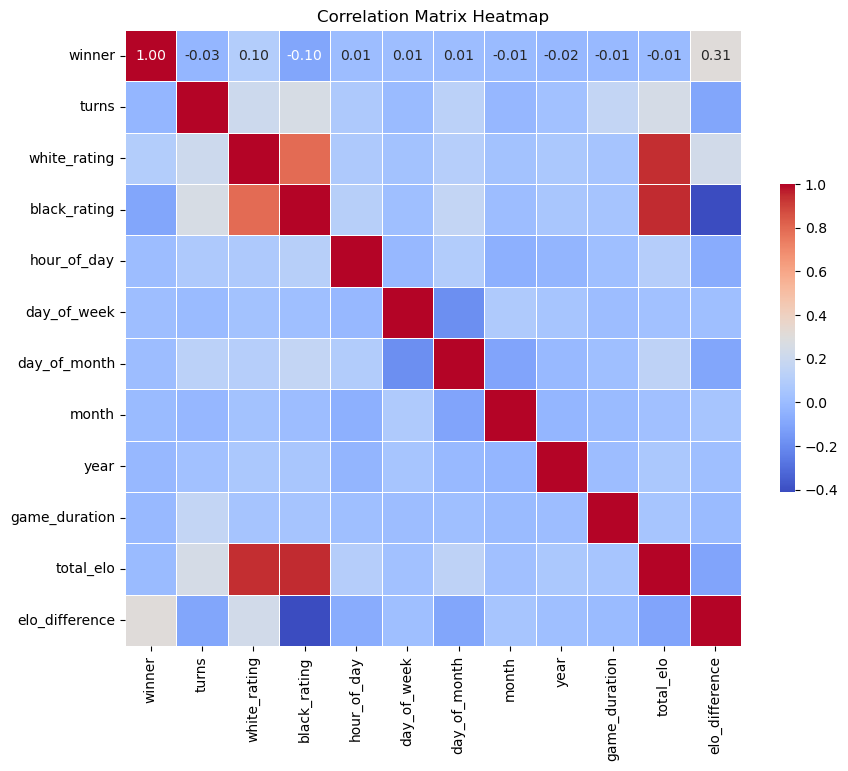

In [25]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

Es ist zu erkennen, dass vor allem die features:
- white_rating
- black_rating 
- elo_difference 

Linear mit dem target-feature 'winner' korrelieren.

Ob neben den hier abgebildeten linearen Korrelationen auch noch weitere bestehen wir im folgenden beim trainieren sowie auswerten des Models untersucht.

## Model Selection, Training und Auswertung

Im folgenden Abschnitt wird:
1. Die zu verwendende Ziel-Metrik festgelegt
2. Verschiedene ML-Methoden getestet und anschließend die performanteste ausgewählt
3. Feature Engineering betrieben
4. Hyperparametertuning  durchgeführt
5. Das Model trainiert
6. Das Model ausgewertet

Als Zielmetrik des Models wird der F1-Score verwendet da dieser als harmonisches Mittel zwischen Recall und Precision eine balancierte Aussage über die Validität des Models geben kann.

Zu Beginn werden nun Modelle auf verschiedenen ML-Methoden trainiert um zu erkunden welche Methode anschließend verwendet wird um ein optimierteres Model zu trainieren.

Hier für werden die Daten in einen 70/30 Train/Test-Split geteilt, es gibt hierbei kein Validation-Split da es nur um die groben unterschiede in der Performance der Methoden geht. Nach der Auswahl der Methode wird ein Validation-Split eingeführt.

Des weiteren wird zur Standartisierung der Daten ein StandardScaler benutzt.

In [26]:
# Remap the target variable 'winner' from -1, 0, 1 to 0, 1, 2 respectively
y = df['winner'].map({-1: 0, 0: 1, 1: 2})

# Extract selected features into X; these features include player ratings, game context, and timing information
X = df[['white_rating', 'black_rating', 'elo_difference', 'turns', 'total_elo', 
        'day_of_week', 'day_of_month', 'hour_of_day', 'month', 'year','game_duration']]

# Split the dataset into training and testing sets with 30% of the data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a scaler to standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
# Transform the testing data with the same scaler
X_test_scaled = scaler.transform(X_test)

# Define a function to train and evaluate machine learning models
def train_evaluate_model(model, X_train, X_test, y_train, y_test, scale=False):
    # If scaling is needed, use the scaled training and testing sets
    if scale:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Generate a classification report and extract the weighted F1-score
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    
    # Print the model's name and F1-score followed by the full classification report
    print(f"\n{model.__class__.__name__} F1 Score:", f1_score)
    print(classification_report(y_test, y_pred))
    return model, f1_score

# List of machine learning models to be trained and evaluated, specifying if they need feature scaling
models = [
    (LogisticRegression(max_iter=1000), True),
    (DecisionTreeClassifier(), False),
    (RandomForestClassifier(), False),
    (SVC(), True),
    (KNeighborsClassifier(), True),
    (GradientBoostingClassifier(), False),
    (MLPClassifier(max_iter=1000), True),
    (AdaBoostClassifier(), False),
    (GaussianNB(), False),
    (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), False),
    (LGBMClassifier(), False)
]

# Iterate over the list of models, train and evaluate each, and store the results
results = []
for model, needs_scaling in models:
    results.append(train_evaluate_model(model, X_train, X_test, y_train, y_test, scale=needs_scaling))


/Users/john-thomas/anaconda3/envs/DEP/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



LogisticRegression F1 Score: 0.5689940970006863
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2540
           1       0.63      0.52      0.57      1476
           2       0.54      0.61      0.57      2732

    accuracy                           0.57      6748
   macro avg       0.58      0.56      0.57      6748
weighted avg       0.57      0.57      0.57      6748


DecisionTreeClassifier F1 Score: 0.5946290752331308
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2540
           1       0.71      0.71      0.71      1476
           2       0.57      0.57      0.57      2732

    accuracy                           0.59      6748
   macro avg       0.61      0.61      0.61      6748
weighted avg       0.59      0.59      0.59      6748


RandomForestClassifier F1 Score: 0.6673734793442886
              precision    recall  f1-score   support

           0       0.60     

Der Test ergibt, das die beiden Performantesten Methoden der LGBM-Classifier und der XGBC-Classifier sind.

Die Performance beider Modelle ist fast exakt gleich somit ist die Auswahl hier nach persöhnlicher Präferenz.

Für das nun zu trainierende Model wähle ich den LGBM-Classifier. 

Der LGBM Classifier hat gegenüber dem XGBC Classifier folgende Vorteile:
1. Die Modelle lassen sich schneller trainieren
2. Geringerer Speicherverbrauch
3. Es kann schneller durch Modelle itteriert werden

Somit kann die minimale Performance-Einbuße im Vergleich zum XGBC Classifier in kauf genommen werden.

Um nun das best mögliche Modell trainieren zu können wird zuerst mit GridsearchCV Hyperparametertuning betrieben.

In [27]:
# Remapping target variable y: mapping values from {-1: 0, 0: 1, 1: 2} for a better interpretation in model
y = df['winner'].map({-1: 0, 0: 1, 1: 2})

# Extract features (X): selecting specific features from the DataFrame that will be used for modeling
X = df[['white_rating', 'black_rating', 'elo_difference', 'turns', 'total_elo', 'day_of_week', 'day_of_month', 'hour_of_day', 'month', 'year', 'game_duration']]

# Split your data into training and testing sets, with 30% of data used as the test set, ensuring reproducibility using a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features using StandardScaler which removes the mean and scales features to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same scaler

# Define the model, using LightGBM Classifier, a gradient boosting framework that uses tree based learning algorithms
model = LGBMClassifier(verbosity=-1)

# Define a parameter grid to tune the LightGBM Classifier, exploring combinations of different values of num_leaves, max_depth, learning_rate, and n_estimators
param_grid = {
    'num_leaves': [30, 40, 50],          # Number of leaves in full tree
    'max_depth': [15, 25, 35],           # Maximum tree depth for base learners
    'learning_rate': [0.05, 0.1, 0.15],  # Boosting learning rate
    'n_estimators': [100, 150, 200]      # Number of boosted trees to fit
}

# Initialize the GridSearchCV object with 3-fold cross-validation, setting verbosity to 0 to suppress log messages
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0, n_jobs=-1)

# Fit the grid search to the data, optimizing the parameters
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score achieved during the GridSearch
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)

# Evaluate the best model from grid search on the test data, calculating accuracy and displaying the classification report for detailed metrics
print("Test Accuracy of Best Model: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 200, 'num_leaves': 30}
Best accuracy found:  0.8591209349593495
Test Accuracy of Best Model:  0.8645524599881447
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      2540
           1       0.97      0.82      0.89      1476
           2       0.84      0.88      0.86      2732

    accuracy                           0.86      6748
   macro avg       0.88      0.86      0.87      6748
weighted avg       0.87      0.86      0.87      6748



Durch GridSearchCV haben wir nun die "besten" Hyperparameter für unser Model:
- learning_rate = 0.1
- max_depth = 25
- n_estimators = 200
- num_leaves = 30

Damit können wir nun Den LGBM Classifer trainieren.

Um nun das Model trainieren und auswerten zu können müssen wir zuerst unsere Daten in Train-Test-Validation Split teilen.

Hierbei wird ein Split von 60/20/20 verwendet somit wird ein Großteil der Daten für das Training benutzt und selbe Anteile für training und validation.

Um die Performance des Classifiers zu vergleichen werden außerdem einige Dummy Classifier trainiert um als Vergleichspunkte zu dienen. 

Auch die tatsächliche Feature Importance wird untersucht und am ende Ausgegeben.

Anschließend werden die Ergebnisse Visualisiert und ausgewertet.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 13494, number of used features: 11
[LightGBM] [Info] Start training from score -0.992008
[LightGBM] [Info] Start training from score -1.529635
[LightGBM] [Info] Start training from score -0.885389


/Users/john-thomas/anaconda3/envs/DEP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/john-thomas/anaconda3/envs/DEP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/john-thomas/anaconda3/envs/DEP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

     Feature Names  Feature Importance
0            turns                5267
10  elo_difference                1855
8    game_duration                1357
3      hour_of_day                1349
1     white_rating                1328
5     day_of_month                1294
2     black_rating                1261
6            month                1114
9        total_elo                1074
4      day_of_week                1060
7             year                 441
Test Set Performance (Model):
F1 Score: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1687
           1       0.97      0.81      0.88       985
           2       0.84      0.89      0.86      1827

    accuracy                           0.86      4499
   macro avg       0.88      0.85      0.86      4499
weighted avg       0.86      0.86      0.86      4499


Validation Set Performance (Model):
F1 Score: 0.86
Classification Report:
        

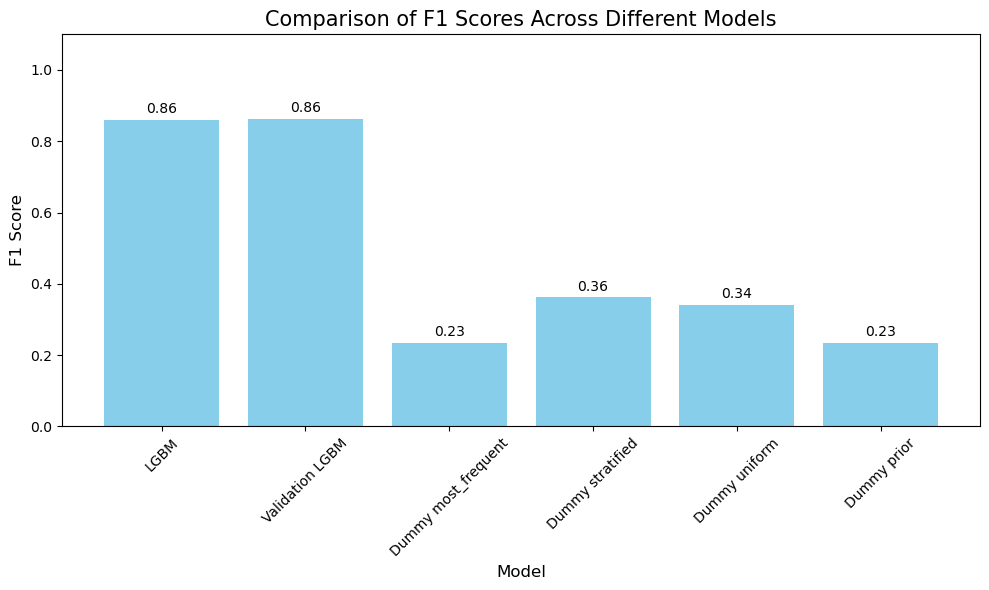

In [28]:

# Load dataset
y = df['winner'].map({-1: 0, 0: 1, 1: 2})  # Adjust the mapping accordingly
X = df.drop('winner', axis=1)  # Adjust the feature names accordingly

# Split data into training plus validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split training plus validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Model initialization and training 'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 200, 'num_leaves': 30
model = LGBMClassifier(num_leaves=30, max_depth=25, learning_rate=0.1, n_estimators=200)
model.fit(X_train_scaled, y_train)

# Define different strategies for Dummy Classifier
strategies = ['most_frequent', 'stratified', 'uniform', 'prior']

# Create a dictionary to store results
dummy_results = {}

# Loop through strategies
for strategy in strategies:
    # Dummy Classifier
    dummy_classifier = DummyClassifier(strategy=strategy)
    dummy_classifier.fit(X_train_scaled, y_train)
    
    # Predictions using Dummy Classifier
    dummy_pred = dummy_classifier.predict(X_test_scaled)
    
    # Evaluate the dummy classifier on the test set
    dummy_f1_score = f1_score(y_test, dummy_pred, average='weighted')
    dummy_report = classification_report(y_test, dummy_pred)
    
    # Store results
    dummy_results[strategy] = {'f1_score': dummy_f1_score, 'classification_report': dummy_report}

# Predictions on test set
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model on the test set
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
test_report = classification_report(y_test, y_test_pred)

# Predictions on validation set
y_val_pred = model.predict(X_val_scaled)

# Evaluate the model on the validation set
val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
val_report = classification_report(y_val, y_val_pred)

# Extract feature importance from the trained model
feature_importances = model.feature_importances_
features_df = pd.DataFrame({
    'Feature Names': X.columns,
    'Feature Importance': feature_importances
}).sort_values(by='Feature Importance', ascending=False)


print(features_df)

# Printing performance metrics
print("Test Set Performance (Model):")
print("F1 Score: {:.2f}".format(test_f1_score))
print("Classification Report:")
print(test_report)

print("\nValidation Set Performance (Model):")
print("F1 Score: {:.2f}".format(val_f1_score))
print("Classification Report:")
print(val_report)

# Printing performance metrics for Dummy Classifiers
print("\nDummy Classifier Performance:")
for strategy, result in dummy_results.items():
    print("\nStrategy:", strategy)
    print("F1 Score (Dummy): {:.2f}".format(result['f1_score']))
    print("Classification Report (Dummy):")
    print(result['classification_report'])


# F1 scores from the primary model and dummy classifiers
model_f1_scores = {
    'LGBM': test_f1_score,  # F1 score of the primary model on the test set
    'Validation LGBM': val_f1_score  # F1 score of the primary model on the validation set
}

# Merge dummy classifier scores with the primary model scores
model_f1_scores.update({f"Dummy {strategy}": result['f1_score'] for strategy, result in dummy_results.items()})

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
models = list(model_f1_scores.keys())
scores = list(model_f1_scores.values())
bars = ax.bar(models, scores, color='skyblue')

# Adding numbers on top of the columns
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Comparison of F1 Scores Across Different Models', fontsize=15)
ax.set_ylim([0, 1.1])  # Slightly increase ylim to accommodate text labels on top
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()


Es ist zu erkennen, dass das Model einen F1-Score von 0.87 auf dem Test-Set und 0.86 auf dem Validation Set erreicht.

Diese Ergebnisse sind äußerst zufriedenstellend da sie den Dummy-Classifiern deutlich überlegen sind.

Man kann außerdem sehen, dass anscheinend das Feature 'turns' eine sehr hohe Importance besitzt was vorher aus der Korrelationsmatrix nicht abzusehen war.

Ein interesanter Abschließender Test wäre es wenn wir nun noch die Feature 'turn' & 'game_duration' entfernen und somit sehe wie gut das Model performen würde wenn es nur Daten verwendet die vor dem Spiel bekannt sind.



In [29]:

X_train_no_turns = X_train.drop(['turns', 'game_duration'], axis=1)
X_test_no_turns = X_test.drop(['turns', 'game_duration'], axis=1)

# Re-scale data
scaler.fit(X_train_no_turns)
X_train_no_turns_scaled = scaler.transform(X_train_no_turns)
X_test_no_turns_scaled = scaler.transform(X_test_no_turns)

# Re-train model
model.fit(X_train_no_turns_scaled, y_train)
y_pred_no_turns = model.predict(X_test_no_turns_scaled)

# Evaluate performance
new_accuracy = accuracy_score(y_test, y_pred_no_turns)
print("New Accuracy without 'turns': {:.2f}%".format(new_accuracy * 100))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 13494, number of used features: 9
[LightGBM] [Info] Start training from score -0.992008
[LightGBM] [Info] Start training from score -1.529635
[LightGBM] [Info] Start training from score -0.885389
New Accuracy without 'turns': 66.48%


Trotz des entfernens der Feature erreicht das Model immernoch einen guten Score von 67,57% Accuracy was immernoch weit über dem wert der Dummy-Classifier liegt.

Zusammenfassend lässt sich das Projekt also als geglückt beschreiben, es wurde ein Model mit einer guten bis sehr guten Performance trainiert welches das Ergebniss von Schachspielen vor der Partie und nach der Partie vorhersagen kann.